In [ ]:
source("/work_ikmb/sukmb667/projects/cdr3-qtl/healthy_and_ibd/scripts/R_functions/hla_functions.R")
source('/work_ikmb/sukmb667/projects/cdr3-qtl/healthy_and_ibd/scripts/libraries_visuals.R')

### Preparing CDR3_HLA_matrices and running the model

In [104]:
ids_to_remove <- read.table('../data/ids_to_remove_duplicates.txt')$V1

In [2]:
cdr3_freq <- fread('../data/cdr3_all_freq_with_IRT.tsv')

In [123]:
cdr3_public_L_P <- split(cdr3_freq, by = c("length_seq", "IMGT"))

In [ ]:
cdr3_public_L_P[[1]]

In [127]:
patients_ids_cdr3 <- unique(cdr3_freq$patient_id)
hla_features <- read_tsv('../data/hla_features_wo_duplicates_healthy_and_ibd.tsv') %>% filter(patient_id %in% patients_ids_cdr3)

Rows: 32320 Columns: 4
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): patient_id, gene, allele
dbl (1): homo_hetero

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
hla_features %>% filter(patient_id == 'H7')

### Check hla_matrices for correlated columns and remove the correlated ones

In [144]:
patients_ids_hla <- unique(hla_features$patient_id)
n_ids <- length(patients_ids_cdr3)
hla_genes = c('A', 'B', 'C', 'DPA1', 'DPB1', 'DQA1', 'DQB1','DRB1')
hla_matrices <- paste0('../hla_matrices_v3/all/',list.files('../hla_matrices_v3/all/'))

In [211]:
for (f in hla_matrices){
    name_hla_matrix <- paste0('wo_corr_',unlist(strsplit(f, '/'))[[4]])
    hla_matrix <- read_tsv(f)
    hla_matrix_wo_correlated <- remove_correlated_columns(hla_matrix, 'allele')
    write_tsv(hla_matrix_wo_correlated, paste0('../hla_matrices_v3/wo_correlation/', name_hla_matrix))
}

Rows: 1900 Columns: 4
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): patient_id, G_S
dbl (2): allele_P, allele_S

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1900 Columns: 4
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): patient_id, G_S
dbl (2): allele_G, allele_W

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_type

In [212]:
length(list.files('../hla_matrices_v3/wo_correlation/'))

[1] 280

In [213]:
manova_template <- read_tsv('../manova_results_v2.tsv')[0,]
manova_template

Rows: 39902 Columns: 13
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): pair, model
dbl (11): Res.Df, Df, Gen.var., Pillai, approx.F, num.Df, den.Df, Pr..F., Om...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Res.Df Df Gen.var. Pillai approx.F num.Df den.Df Pr..F. pair Omnibus model
     P_val variance_explained

In [ ]:
dir_pair_path <- paste0('../cdr3_hla_pairs_v3/')
dir_results <- paste0('../manova_results_v3/')
    
if (!file.exists(dir_pair_path)) {
dir.create(dir_pair_path, recursive = TRUE)
}
if (!file.exists(dir_results)) {
dir.create(dir_results, recursive = TRUE)
}

hla_matrices <- paste0('../hla_matrices_v3/wo_correlation/',list.files('../hla_matrices_v3/wo_correlation/'))
manova_df_all <- manova_template

for (L_P_group in seq(1,length(cdr3_public_L_P))){

    cdr3_L_P <- cdr3_public_L_P[[L_P_group]]
    L <- unique(cdr3_L_P$length)
    P <- unique(cdr3_L_P$IMGT)
    
    cdr3_matrix <- cdr3_matrix_fun(cdr3_L_P)
    cdr3_matrix$L_P <- paste0(L,':',P)
    
    ind_in_cdr3 <- unique(cdr3_L_P$patient_id)
    
    pca_hla <- pca_hla_fun(hla_features %>% filter(patient_id %in% ind_in_cdr3))

    for (f in hla_matrices){
        
        hla_matrix <- read_tsv(f) %>% filter(patient_id %in% ind_in_cdr3)
        
        cdr3_hla_matrix <- hla_matrix %>%
            inner_join(cdr3_matrix, by='patient_id') %>% unite('pair', G_S,L_P, sep = ':')
        name_pair <- cdr3_hla_matrix$pair[1]
             
        cdr3_hla_matrix_pca <- cdr3_hla_matrix %>% 
            inner_join(pca_hla, by = 'patient_id')
        write_tsv(cdr3_hla_matrix_pca, paste0(dir_pair_path,name_pair,'_matrix.tsv'))
        
        
        manova_df <- mlm_fun(cdr3_hla_matrix_pca, dir_results)
     
        manova_df_all <- bind_rows(manova_df_all, manova_df)
    }

    
}

write_tsv(manova_df_all, '../manova_results_v3.tsv')


Rows: 1900 Columns: 3
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): patient_id, G_S
dbl (1): allele_S

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in data.frame(Omnibus, model = c("null", "full"), P_val, variance_explained):
“row names were found from a short variable and have been discarded”
Rows: 1900 Columns: 3
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): patient_id, 

## Permutation test

#### Shuffle HLA and preparing HLA variation table

In [123]:
hla <- fread('../permutation_test//HLA_of_healthy_and_ibd_all_samples.tsv') 
n_alleles_per_gene <- length(unique(read.table('../data/ids_in_cdr3.txt')$V1)) * 2

In [126]:
n_alleles_per_gene*0.01

[1] 38.44

#### preparing cdr3-hla matrices with prepared hla_matrices

In [ ]:
hla_genes = c('A','B','C','DPA1','DPB1','DQA1', 'DQB1','DRB1')

dir_pair <- paste0('../permutation_test/cdr3_hla_pairs/')
dir_results <- paste0('../permutation_test/manova_results_permutation/')
    
if (!file.exists(dir_pair)) {
dir.create(dir_pair, recursive = TRUE)
}
if (!file.exists(dir_results)) {
dir.create(dir_results, recursive = TRUE)
}

manova_template <- read_tsv('../manova_results_v2.tsv')[0,]

cdr3_freq <- fread('../data/cdr3_freq_healthy_and_ibd_public_v2.tsv')
cdr3_public_L_P <- split(cdr3_freq, by = c("length", "IMGT"))


for (n_permut in seq(2,100)){
    hla$patient_id <- sample(hla$patient_id)
    hla_features <- hla %>% 
        pivot_longer(cols = (- 'patient_id'), names_to = 'genes', values_to = 'allele') %>%     
        separate(genes, into = c('gene', 'gene_copy'), sep = '\\.', remove = TRUE) %>%
        mutate(allele = paste0(gene,'*', allele)) %>% 
        select(-gene_copy) %>%
        distinct() %>%
        group_by(patient_id, gene) %>%
        mutate(homo_hetero = ifelse((length(allele) == 1), 2, 1)) %>%
        ungroup()
    hla_features <- hla_features[!grepl('00:00',hla_features$allele),]
    
    path <- paste0("../permutation_test/hla_matrices/", n_permut, "/")
        if (!file.exists(path)) {
            dir.create(path, recursive = TRUE)
            }
    for (gene_name in hla_genes){   
        hla_reference_long <- read.csv(paste0("../../reference_data/hla_msa/",gene_name, "_long.tsv"), sep = '\t')
    
        hla_patients <- hla_features %>%
            filter(gene == gene_name) %>% 
            inner_join(hla_reference_long, relationship = "many-to-many", by = join_by(allele))  %>%
            group_by(site) %>%
            mutate(variat = list(unique(AA)), n_variat = lengths(variat)) %>%
            filter(n_variat >= 2) %>%
            ungroup()
        
        hla_patients_proper_sites <- hla_patients %>%
            group_by(site, AA) %>%
            summarise(n_allele_carriers = sum(homo_hetero), .groups = 'keep') %>% 
            right_join(hla_patients, by = c('site', 'AA')) %>% 
            ungroup() %>%
            group_by(site) %>%
            mutate(site_to_remove = ifelse(n_allele_carriers >= n_alleles_per_gene*0.95, 'yes', 'no')) %>%
            filter(site_to_remove == 'no') %>%
            filter(n_allele_carriers >= n_alleles_per_gene*0.05) %>%
            ungroup()
        
        
        site_split <- hla_patients_proper_sites %>% select(patient_id, homo_hetero, site, AA) %>% 
            group_by(patient_id, site, AA) %>%
            summarise(homo_hetero = sum(homo_hetero), .groups = 'keep') %>%
            ungroup() %>%
            group_split(site)
        
    
        for (site in seq(1, length(site_split))){
            site_location <- site_split[[site]]$site[1]
            site_matrix <- site_split[[site]] %>% select(-site) %>% 
                pivot_wider(names_from=AA, values_from = homo_hetero, values_fn = sum, values_fill = 0, names_prefix = 'allele_')
            site_matrix$G_S <- paste0(gene_name,':',site_location)
            
            write_tsv(site_matrix, paste0(path,gene_name, "_",site_location, "_matrix.tsv"))
        }
    }
    
    hla_matrices <- paste0(path, list.files(path))
    
    dir_pair_path <- paste0(dir_pair, n_permut, '/')
    if (!file.exists(dir_pair_path)) {
        dir.create(dir_pair_path, recursive = TRUE)
        }
    
    manova_df_all <- manova_template
    
    for (L_P_group in seq(1,length(cdr3_public_L_P))){
    
        cdr3_L_P <- cdr3_public_L_P[[L_P_group]]
        L <- unique(cdr3_L_P$length)
        P <- unique(cdr3_L_P$IMGT)
        
        cdr3_matrix <- cdr3_matrix_fun(cdr3_L_P)
        cdr3_matrix$L_P <- paste0(L,':',P)
        
        ind_in_cdr3 <- unique(cdr3_L_P$patient_id)
        
        for (f in hla_matrices){
            
            hla_matrix <- read_tsv(f) %>% filter(patient_id %in% ind_in_cdr3)
            pca_hla <- pca_hla_fun(hla_features %>% filter(patient_id %in% ind_in_cdr3))
            
            cdr3_hla_matrix <- hla_matrix %>%
                inner_join(cdr3_matrix, by='patient_id') %>% unite('pair', G_S,L_P, sep = ':')
            name_pair <- cdr3_hla_matrix$pair[1]
                 
            cdr3_hla_matrix_pca <- cdr3_hla_matrix %>% 
                inner_join(pca_hla, by = 'patient_id')

            
            write_tsv(cdr3_hla_matrix_pca, paste0(dir_pair_path,name_pair,'_matrix.tsv'))
            
            manova_df <- mlm_fun_permutation(cdr3_hla_matrix_pca)
        
            manova_df_all <- bind_rows(manova_df_all, manova_df)
        }
        
    }
    
    write_tsv(manova_df_all, paste0(dir_results,'manova_', n_permut,'.tsv'))
}

Rows: 39902 Columns: 13
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): pair, model
dbl (11): Res.Df, Df, Gen.var., Pillai, approx.F, num.Df, den.Df, Pr..F., Om...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2292 Columns: 4
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): patient_id, G_S
dbl (2): allele_S, allele_P

ℹ Use `spec()` to retrieve the full column specification for this dat

In [113]:
zero_allele <- site_matrix %>% select(where(is.numeric))
colnames(zero_allele[,colSums(zero_allele) != 0])

[1] "allele_R" "allele_T"

In [91]:
cdr3_hla_matrix_pca
#lm(dependent_variable ~ ., data = cdr3_hla_matrix_pca)
#vif(vif_model)
amino_acids <-c('A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y') 
name_pair <- unique(cdr3_hla_matrix_pca$pair)

without_ref_allele <- cdr3_hla_matrix_pca %>% 
        summarise(across(contains('allele'), sum)) %>% t() %>% as.data.frame() %>% arrange(desc(V1)) %>% slice(-1) %>% rownames()
aa_in_matrix <- paste0(colnames(cdr3_hla_matrix)[colnames(cdr3_hla_matrix) %in% amino_acids], collapse = ',')


formula_full <- as.formula(paste0(paste0('cbind(',aa_in_matrix,') ~'), paste0(without_ref_allele, collapse = '+'), '+PC1+PC2+PC3'))
formula_null <- as.formula(paste0('cbind(',aa_in_matrix,') ~', 'PC1+PC2+PC3'))

mod1 <- lm(formula_full, data = cdr3_hla_matrix_pca)
mod0 <- lm(formula_null, data = cdr3_hla_matrix_pca)

manova <- anova(mod1, mod0)

patient_id allele_E allele_T allele_K allele_M allele_G pair        
1    H0         1        1        0        0        0        B:45:12:P106
2    H1         0        0        1        1        0        B:45:12:P106
3    H10        2        0        0        0        0        B:45:12:P106
4    H100       0        0        1        1        0        B:45:12:P106
5    H101       0        0        2        0        0        B:45:12:P106
6    H102       1        1        0        0        0        B:45:12:P106
7    H103       0        0        1        1        0        B:45:12:P106
8    H104       0        1        0        1        0        B:45:12:P106
9    H105       1        1        0        0        0        B:45:12:P106
10   H106       0        0        2        0        0        B:45:12:P106
11   H107       1        0        0        1        0        B:45:12:P106
12   H108       1        0        1        0        0        B:45:12:P106
13   H109       1        1        0        0        0        B:45:12:P106
14   H11        1        1        0        0        0        B:45:12:P106
15   H110       1        0        1        0        0        B:45:12:P106
16   H111       1        1        0        0        0        B:45:12:P106
17   H112       0        1        1        0        0        B:45:12:P106
18   H113       0        2        0        0        0        B:45:12:P106
19   H114       0        0        1        1        0        B:45:12:P106
20   H115       0        0        0        2        0        B:45:12:P106
21   H116       0        1        0        1        0        B:45:12:P106
22   H117       1        1        0        0        0        B:45:12:P106
23   H118       0        1        1        0        0        B:45:12:P106
24   H119       1        0        1        0        0        B:45:12:P106
25   H12        2        0        0        0        0        B:45:12:P106
26   H120       1        0        0        1        0        B:45:12:P106
27   H121       1        1        0        0        0        B:45:12:P106
28   H122       1        0        0        1        0        B:45:12:P106
29   H123       1        1        0        0        0        B:45:12:P106
30   H124       0        1        1        0        0        B:45:12:P106
⋮    ⋮          ⋮        ⋮        ⋮        ⋮        ⋮        ⋮           
1890 I970       1        1        0        0        0        B:45:12:P106
1891 I972       2        0        0        0        0        B:45:12:P106
1892 I973       1        0        1        0        0        B:45:12:P106
1893 I974       1        0        1        0        0        B:45:12:P106
1894 I975       1        0        0        1        0        B:45:12:P106
1895 I976       2        0        0        0        0        B:45:12:P106
1896 I977       0        1        1        0        0        B:45:12:P106
1897 I978       0        0        2        0        0        B:45:12:P106
1898 I979       0        0        1        1        0        B:45:12:P106
1899 I98        2        0        0        0        0        B:45:12:P106
1900 I980       1        0        0        1        0        B:45:12:P106
1901 I982       1        0        0        1        0        B:45:12:P106
1902 I983       0        0        2        0        0        B:45:12:P106
1903 I984       2        0        0        0        0        B:45:12:P106
1904 I985       1        0        1        0        0        B:45:12:P106
1905 I986       0        1        0        1        0        B:45:12:P106
1906 I987       2        0        0        0        0        B:45:12:P106
1907 I988       0        0        2        0        0        B:45:12:P106
1908 I989       2        0        0        0        0        B:45:12:P106
1909 I99        1        0        1        0        0        B:45:12:P106
1910 I990       1        0        1        0        0        B:45:12:P106
1911 I991       1        1        0        0        0        B:45:12:P106
1912 I992

In [93]:
mod1_mvlm <- mvlm(formula_full, cdr3_hla_matrix_pca)
mod0_mvlm <- mvlm(formula_null, cdr3_hla_matrix_pca)

var_exp_full <- mod1_mvlm$pseudo.rsq["Omnibus Effect",1]
p_val_full <- mod1_mvlm$pv["Omnibus Effect",1]

var_exp_null <- mod0_mvlm$pseudo.rsq["Omnibus Effect",1]
p_val_null <- mod0_mvlm$pv["Omnibus Effect",1]

variance_explained <- var_exp_full - var_exp_null

ERROR: Error in solve.default(crossprod(X.full)): Lapack routine dgesv: system is exactly singular: U[5,5] = 0


In [98]:
cdr3_hla_matrix_pca%>%select(contains('allele')) %>% cor()

Warning message in cor(.):
“the standard deviation is zero”


allele_E   allele_T   allele_K   allele_M   allele_G
allele_E  1.0000000 -0.4307597 -0.4367886 -0.3461143 NA      
allele_T -0.4307597  1.0000000 -0.2990934 -0.2156849 NA      
allele_K -0.4367886 -0.2990934  1.0000000 -0.2397856 NA      
allele_M -0.3461143 -0.2156849 -0.2397856  1.0000000 NA      
allele_G         NA         NA         NA         NA  1

In [2]:
manova_df_all <- read_tsv('../manova_results.tsv')

Rows: 6572 Columns: 14
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): pair, model
dbl (11): Res.Df, Df, Gen.var., Pillai, approx.F, num.Df, den.Df, Pr..F., Om...
lgl  (1): var_expl

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
manova_df_all

Res.Df Df Gen.var.  Pillai     approx.F  num.Df den.Df Pr..F.      
1    1932   NA 0.8644027         NA       NA  NA       NA             NA
2    1934    2 0.8647872 0.02933164 1.424409  40     3828   4.084097e-02
3    1932   NA 0.8645208         NA       NA  NA       NA             NA
4    1934    2 0.8647872 0.02665149 1.292497  40     3828   1.032942e-01
5    1931   NA 0.8639377         NA       NA  NA       NA             NA
6    1934    3 0.8647872 0.05020440 1.628778  60     5742   1.619422e-03
7    1930   NA 0.8636942         NA       NA  NA       NA             NA
8    1933    3 0.8644935 0.04912667 1.592398  60     5739   2.557590e-03
9    1932   NA 0.8644979         NA       NA  NA       NA             NA
10   1934    2 0.8647872 0.02718935 1.318941  40     3828   8.670595e-02
11   1932   NA 0.8644602         NA       NA  NA       NA             NA
12   1934    2 0.8647872 0.02805677 1.361618  40     3828   6.459719e-02
13   1931   NA 0.8641857         NA       NA  NA       NA             NA
14   1934    3 0.8647872 0.04456631 1.443103  60     5742   1.450478e-02
15   1932   NA 0.8639819         NA       NA  NA       NA             NA
16   1934    2 0.8647872 0.03890861 1.898715  40     3828   5.721734e-04
17   1932   NA 0.8645593         NA       NA  NA       NA             NA
18   1934    2 0.8647872 0.02578232 1.249795  40     3828   1.353652e-01
19   1932   NA 0.8643027         NA       NA  NA       NA             NA
20   1934    2 0.8647872 0.03162512 1.537575  40     3828   1.665264e-02
21   1930   NA 0.8638812         NA       NA  NA       NA             NA
22   1934    4 0.8647872 0.06173934 1.500270  80     7656   2.697554e-03
23   1931   NA 0.8626746         NA       NA  NA       NA             NA
24   1934    3 0.8647872 0.07859870 2.574756  60     5742   4.256295e-10
25   1932   NA 0.8646419         NA       NA  NA       NA             NA
26   1934    2 0.8647872 0.02389379 1.157142  40     3828   2.303623e-01
27   1932   NA 0.8638293         NA       NA  NA       NA             NA
28   1934    2 0.8647872 0.04220971 2.063280  40     3828   1.001110e-04
29   1931   NA 0.8634255         NA       NA  NA       NA             NA
30   1934    3 0.8647872 0.06181681 2.013445  60     5742   6.597988e-06
⋮    ⋮      ⋮  ⋮         ⋮          ⋮         ⋮      ⋮      ⋮           
6543 1014   NA 0.9276514         NA        NA NA       NA           NA  
6544 1016    2 0.9282526 0.03110817 1.3219195 24     2008   0.13590989  
6545 1014   NA 0.9282932         NA        NA NA       NA           NA  
6546 1016    2 0.9282526 0.02297329 0.9722170 24     2008   0.50065682  
6547 1011   NA 0.9300498         NA        NA NA       NA           NA  
6548 1013    2 0.9295744 0.01749982 0.7363312 24     2002   0.81773997  
6549 1014   NA 0.9285253         NA        NA NA       NA           NA  
6550 1016    2 0.9282526 0.02001077 0.8455775 24     2008   0.67945594  
6551 1014   NA 0.9272823         NA        NA NA       NA           NA  
6552 1016    2 0.9282526 0.03585840 1.5274625 24     2008   0.04874866  
6553 1012   NA 0.9277016         NA        NA NA       NA           NA  
6554 1016    4 0.9282526 0.05398210 1.1445721 48     4016   0.23012923  
6555 1011   NA 0.9289618         NA        NA NA       NA           NA  
6556 1016    5 0.9282526 0.04967005 0.8394849 60     5020   0.80662542  
6557 1014   NA 0.9282917         NA        NA NA       NA           NA  
6558 1016    2 0.9282526 0.02300729 0.9736725 24     2008   0.49862484  
6559 1014   NA 0.9275162         NA        NA NA       NA           NA  
6560 1016    2 0.9282526 0.03288471 1.3986744 24     2008   0.09448757  
6561 1013   NA 0.9272323         NA        NA NA       NA           NA  
6562 1016    3 0.9282526 0.04828362 1.3686037 36     3012   0.07086140  
6563 1013   NA 0.9282357         NA        NA NA       NA           NA  
6564 1015    2 0.9286313 0.02856965 1.2112763 24     2006   0.21938258  
6565 1014   NA 0.9272201         NA        NA NA       NA      

### Visualise corrplot from the cor_list

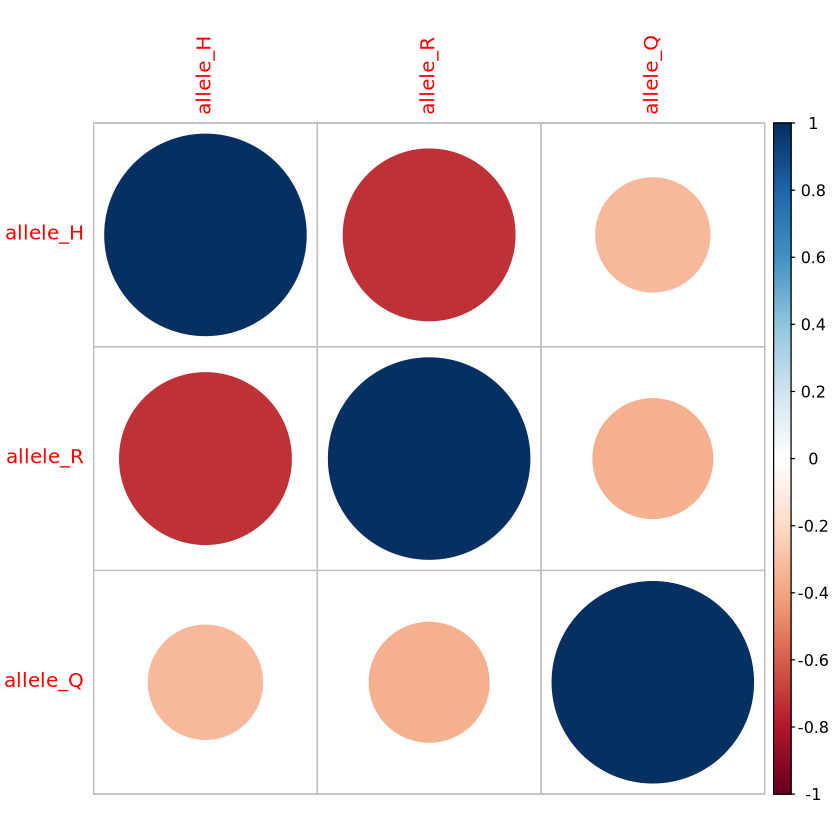

In [64]:
corrplot(cor_list[[1]], method = "circle")

### Script for the POWER analysis

In [ ]:
hla_features <- read_tsv('../hla_features_wo_duplicates.tsv')
patients_ids <- unlist(read.table('../patients_ids_wo_duplicates.txt', header = FALSE)$V1)
n_ids <- length(patients_ids)
hla_gene = c('A', 'B', 'C', 'DPA1', 'DPB1', 'DQA1', 'DQB1','DRB1')


manova_template <- read_tsv('../mmlm_results_2/DRB1_233_12_P108_sample_size_10_replicate_1.tsv')[0,]

for (n in c(1000, 1400, 800,n_ids, 400,600, 200)){
    dir_hla_path <- paste0('../hla_matrices/all_variable')
    dir_pair_path <- paste0('../cdr3_hla_pairs//',n,'/')
    dir_results <- paste0('../mmlm_results_2/',n,'/')
    
    # creating subdirectories if they don't exist
    if (!file.exists(dir_hla_path)) {
    dir.create(dir_hla_path, recursive = TRUE)
    }
    if (!file.exists(dir_pair_path)) {
    dir.create(dir_pair_path, recursive = TRUE)
    }
    if (!file.exists(dir_results)) {
    dir.create(dir_results, recursive = TRUE)
    }

    manova_df_size_pairs <- manova_template
    
    #for each downsampling creating matrices for each replicate
    for (replic in c(3,2,1)){
        sampling_ids <- sample(x = unlist(patients_ids), size  = n)
        write.table(sampling_ids, paste0('../ids_size_',n,'_rep_',replic,'.txt'), row.names = FALSE, quote = TRUE)

        for (gene_name in hla_gene){   
            hla_reference_long <- read.csv(paste0("../../reference_data/hla_msa/",gene_name, "_long.tsv"), sep = '\t')
            
            hla_patients <- hla_features %>%
                filter(gene == gene_name, patient_id %in% sampling_ids) %>% 
                inner_join(hla_reference_long, relationship = "many-to-many", by = join_by(allele)) %>%
                group_by(site, AA) %>%
                mutate(n_carriers = lengths(list(unique(patient_id)))) %>%
                filter(n_carriers >= n*0.025) %>%
                ungroup() %>%
                group_by(site) %>%
                mutate(variat = list(unique(AA)), n_variat = lengths(variat)) %>%
                filter(n_variat >= 2) %>%
                ungroup()
            hla_patients$variat_chr <- sapply(hla_patients$variat, function(x){paste0(x, collapse = '')})
            write_tsv(hla_patients, paste0('../hla/hla_variation_size_',n,'_rep',replic,'.tsv'))
           
            site_split <- hla_patients %>% select(patient_id, homo_hetero, site, AA) %>% 
                group_by(patient_id, site, AA) %>%
                summarize(homo_hetero = sum(homo_hetero), .groups = "keep") %>%
                ungroup() %>%
                group_split(site) 
            for (site in seq(1, length(site_split))){
                site_location <- site_split[[site]]$site[1]
                site_matrix <- site_split[[site]] %>% select(-site) %>% 
                    pivot_wider(names_from=AA, values_from = homo_hetero, values_fn = sum, values_fill = 0, names_prefix = 'allele_')
                site_matrix$G_S <- paste0(gene_name,':',site_location)
                write_tsv(site_matrix, paste0(dir_hla_path,gene_name, "_",site_location, "_size_",n,"_rep_",replic,".tsv"))

                # now at this step we have hla_matrix and we creating hla_cdr3_matrix and going through mmlm
                pivoted_cdr3_public <- pivoted_together_freq %>% 
                    filter(patient_id %in% sampling_ids) %>%
                    group_by(length, IMGT, AA) %>% 
                    mutate(n_carriers = length(unique(patient_id))) %>%
                    ungroup() %>%
                    arrange(n_carriers) %>%
                    filter(n_carriers >= (length(sampling_ids)/2)) %>% 
                    select(-c('total_AA_count', 'total_IMGT_count', 'n_carriers'))


                pivoted_cdr3_public_splitted_L_P <- pivoted_cdr3_public %>% group_by(length, IMGT) %>%
                    group_split()

        
                for (L_P_group in seq(1,length(pivoted_cdr3_public_splitted_L_P))){
                
                    pivoted_cdr3_L_P <- pivoted_cdr3_public_splitted_L_P[[L_P_group]]
                    L <- unique(pivoted_cdr3_public_splitted_L_P[[L_P_group]]$length)
                    P <- unique(pivoted_cdr3_public_splitted_L_P[[L_P_group]]$IMGT)
                    
                        
                    pivoted_cdr3_matrix <- cdr3_matrix(pivoted_cdr3_L_P)
                    pivoted_cdr3_matrix$L_P <- paste0(L,':',P)
                  
                    name_pair <- paste0(gene_name,'_',site_location,'_',L,'_',P)
                    cdr3_hla_matrix <- site_matrix %>%
                        inner_join(pivoted_cdr3_matrix, by='patient_id')
                    write_tsv(cdr3_hla_matrix, paste0('../cdr3_hla_pairs/',n,'/',name_pair,'_matrix_size_',n,'_rep',replic,'.tsv'))
        
                    manova_results <- mlm_fun(cdr3_hla_matrix_pca, dir_results, sample_size = n, replic = replic)
                    manova_df <- manova_results %>% mutate(pair = name_pair, size = n, replic = replic)
                    manova_df_size_pairs <- bind_rows(manova_df_size_pairs, manova_df)
                }
            }
        }
    }
    write_tsv(manova_df_size_pairs, paste0('../manova_results_size_',n,'.tsv'))
}


Rows: 21904 Columns: 4
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): gene, allele
dbl (2): patient_id, homo_hetero

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2 Columns: 14
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): pair, model
dbl (12): Res.Df, Df, Gen.var., Pillai, approx.F, num.Df, den.Df, Pr..F., re...

ℹ Use `spec()` to retrieve the full column specification for this data

### DOWNSAMPLING of CDR3

## Annotations of genes and visualisation: all variable sites and highly variable - present in a side-to-side way for comparison

### put all variable and highly variable in one df

In [20]:
n_tests <- length(list.files('../cdr3_hla_pairs/all_variable_sites/')) * 12 # because on average we have 12 amino acids in the matrix 
bonf <- 0.05/n_tests
manova_df_all <- read_tsv('../manova_results_all_variable_sites.tsv') %>% 
    separate(pair, into = c('gene', 'site', 'length', 'position'), sep = ':', remove = FALSE) %>% 
    mutate(site = as.numeric(site), length = as.numeric(length),
           significance = ifelse(Pr..F. <= bonf, 'yes', 'no'),
           batch = 'all_variable_sites')

n_tests_high <- length(list.files('../cdr3_hla_pairs/highly_variable_sites/')) * 12 # because on average we have 12 amino acids in the matrix 
bonf_high <- 0.05/n_tests_high
manova_df_high <- read_tsv('../manova_results.tsv') %>% 
    separate(pair, into = c('gene', 'site', 'length', 'position'), sep = ':', remove = FALSE) %>% 
    mutate(site = as.numeric(site), length = as.numeric(length),
           significance = ifelse(Pr..F. <= bonf_high, 'yes', 'no'),
           batch = 'highly_variable_sites')

manova_df_both <- bind_rows(manova_df_all, manova_df_high) 

Rows: 34844 Columns: 13
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): pair, model
dbl (11): Res.Df, Df, Gen.var., Pillai, approx.F, num.Df, den.Df, Pr..F., Om...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 6572 Columns: 14
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): pair, model
dbl (11): Res.Df, Df, Gen.var., Pillai, approx.F, num.Df, den.Df, Pr..F., Om...
lgl  (1): var_expl



In [3]:
hla_annotations <- read.csv('../../reference_data//hla_annotations.csv', sep =';')

### Visualisation of MANOVA in gene-wise manner

In [49]:
hla_interest <- manova_df_both %>% filter(gene == 'B') 

hla_interest_sites_of_interest <- hla_interest %>% filter(significance == 'yes') %>% filter(site %in% c(9,156,97, 325)) %>% 
    mutate(highlighed_cdr3_positions = ifelse(position %in% c('P109','P110', 'P114', 'P115', 'P113'), position, NA))

In [50]:
hla_interest_sites_of_interest %>% arrange(Pr..F.)

Res.Df Df Gen.var.  Pillai     approx.F num.Df den.Df Pr..F.      
1   1954   3  0.8602092 0.15266420 5.184716 60     5802   2.045449e-34
2   1954   3  0.8602092 0.15266420 5.184716 60     5802   2.045449e-34
3   1954   2  0.8470741 0.10408238 5.308651 40     3868   1.607124e-24
4   1954   2  0.8470741 0.10408238 5.308651 40     3868   1.607124e-24
5   1953   2  0.8597441 0.09868252 5.283095 38     3868   2.820027e-23
6   1953   2  0.8597441 0.09868252 5.283095 38     3868   2.820027e-23
7   1949   2  0.8442737 0.10043723 5.099685 40     3858   4.164979e-23
8   1949   2  0.8442737 0.10043723 5.099685 40     3858   4.164979e-23
9   1954   3  0.8470741 0.11462985 3.841693 60     5802   2.853873e-21
10  1954   3  0.8470741 0.11462985 3.841693 60     5802   2.853873e-21
11  1954   3  0.8322340 0.11383579 3.814031 60     5802   5.195045e-21
12  1954   3  0.8322340 0.11383579 3.814031 60     5802   5.195045e-21
13  1954   1  0.8470741 0.07049424 7.333783 20     1934   2.080891e-20
14  1954   2  0.8602092 0.09184700 4.654556 40     3868   3.893097e-20
15  1954   2  0.8602092 0.09184700 4.654556 40     3868   3.893097e-20
16  1953   5  0.8439058 0.13972176 2.926212 95     9670   1.826687e-19
17  1947   3  0.8354072 0.10505226 3.682291 57     5784   6.472887e-19
18  1947   3  0.8354072 0.10505226 3.682291 57     5784   6.472887e-19
19  1947   5  0.8354072 0.13679652 2.854342 95     9640   1.665059e-18
20  1952   3  0.8685073 0.10505495 3.505527 60     5796   3.784932e-18
21  1952   3  0.8685073 0.10505495 3.505527 60     5796   3.784932e-18
22  1924   2  0.8357949 0.08246376 4.311823 38     3810   4.121307e-17
23  1930   2  0.8463180 0.08184645 4.291642 38     3822   5.479370e-17
24  1947   3  0.8390747 0.09903378 3.289216 60     5781   3.444906e-16
25  1947   3  0.8390747 0.09903378 3.289216 60     5781   3.444906e-16
26  1953   2  0.8586549 0.08018210 4.036633 40     3866   4.157218e-16
27  1953   2  0.8586549 0.08018210 4.036633 40     3866   4.157218e-16
28  1952   5  0.8311743 0.12732571 2.658441 95     9665   5.937544e-16
29  1953   2  0.8439058 0.07776225 4.117794 38     3868   6.394065e-16
30  1953   2  0.8439058 0.07776225 4.117794 38     3868   6.394065e-16
⋮   ⋮      ⋮  ⋮         ⋮          ⋮        ⋮      ⋮      ⋮           
97  1950   5  0.8763806 0.09688841 2.008301  95    9655   2.712232e-08
98  1947   2  0.8390747 0.05506065 2.727639  40    3854   3.497194e-08
99  1947   2  0.8390747 0.05506065 2.727639  40    3854   3.497194e-08
100 1927   2  0.8776491 0.05386317 2.779350  38    3816   3.802662e-08
101 1930   2  0.8529990 0.05505693 2.703389  40    3820   4.786736e-08
102 1943   5  0.8401425 0.09561105 1.974125  95    9620   6.192800e-08
103 1925   2  0.8303883 0.05313939 2.738111  38    3812   6.321359e-08
104 1950   3  0.8685847 0.06966123 2.294038  60    5790   6.423636e-08
105 1950   3  0.8685847 0.06966123 2.294038  60    5790   6.423636e-08
106 1947   3  0.8295808 0.06748388 2.335141  57    5784   6.515247e-08
107 1947   3  0.8295808 0.06748388 2.335141  57    5784   6.515247e-08
108 1952   2  0.8311743 0.05226590 2.730028  38    3866   6.951703e-08
109 1952   2  0.8311743 0.05226590 2.730028  38    3866   6.951703e-08
110 1944   5  0.8450542 0.09855613 1.934348 100    9620   8.001469e-08
111 1953   2  0.8537581 0.05302788 2.632367  40    3866   1.177197e-07
112 1953   2  0.8537581 0.05302788 2.632367  40    3866   1.177197e-07
113 1952   5  0.8685073 0.09717036 1.914539 100    9660   1.300235e-07
114 1952   3  0.8241153 0.06832669 2.251396  60    5796   1.333970e-07
115 1952   3  0.8241153 0.06832669 2.251396  60    5796   1.333970e-07
116 1954   2  0.8322340 0.05274008 2.619047  40    3868   1.392559e-07
117 1954   2  0.8322340 0.05274008 2.619047  40    3868   1.392559e-07
118 1954   3  0.8563843 0.06560156 2.276787  57    5805   1.704257e-07
119 1954   3  0.8563843 0.06560156 2.276787  57    5805   1.704257e-07
120 1931   2  0.8561596 0.05078675 2.621955  38    3824   2.590544e-07
121 1931   2  0.8480457 0.05

Warning message:
“Removed 3410 rows containing missing values or values outside the scale range (`geom_point()`).”


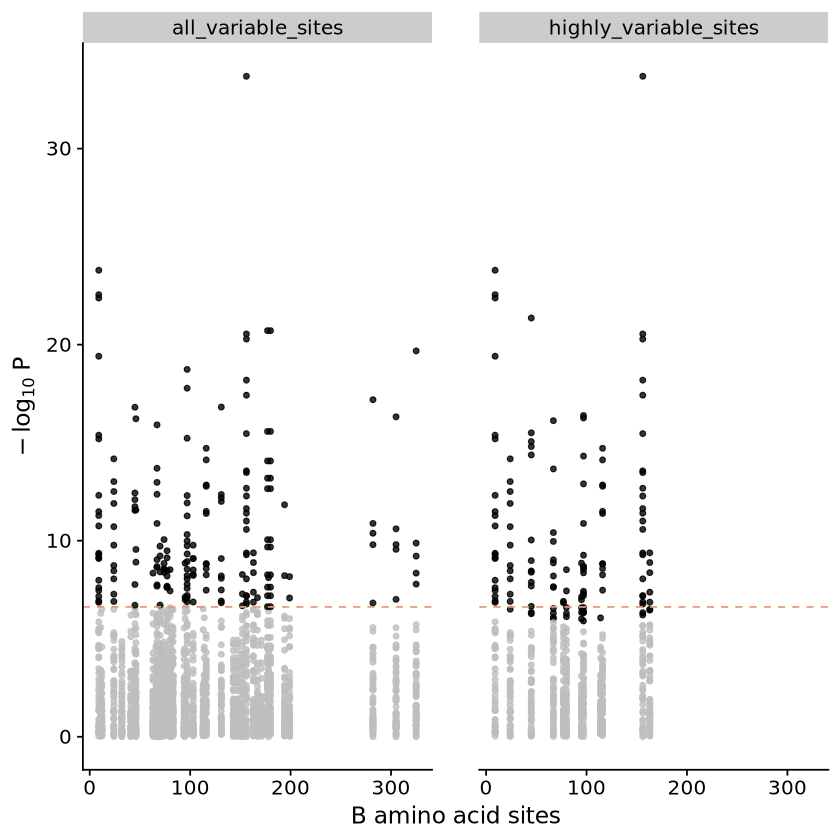

In [40]:
ggplot() + 
    geom_point(data = hla_interest, aes(x = site, y = -log10(Pr..F.), color = significance), show.legend = FALSE, alpha=0.8, size=1.3) +
    scale_color_manual(values = c('yes' = 'black', 'no' = 'grey')) +
    labs(x = "B amino acid sites", y = expression(paste(-log[10], " ", P))) +
    geom_hline(yintercept= - log10(bonf), linetype="dashed", color = "darksalmon") +
    facet_wrap(~batch) +
    theme_cowplot() +
    theme(panel.spacing = unit(1, "cm"))

Warning message:
“Removed 3410 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 49 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 3410 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 49 rows containing missing values or values outside the scale range (`geom_point()`).”


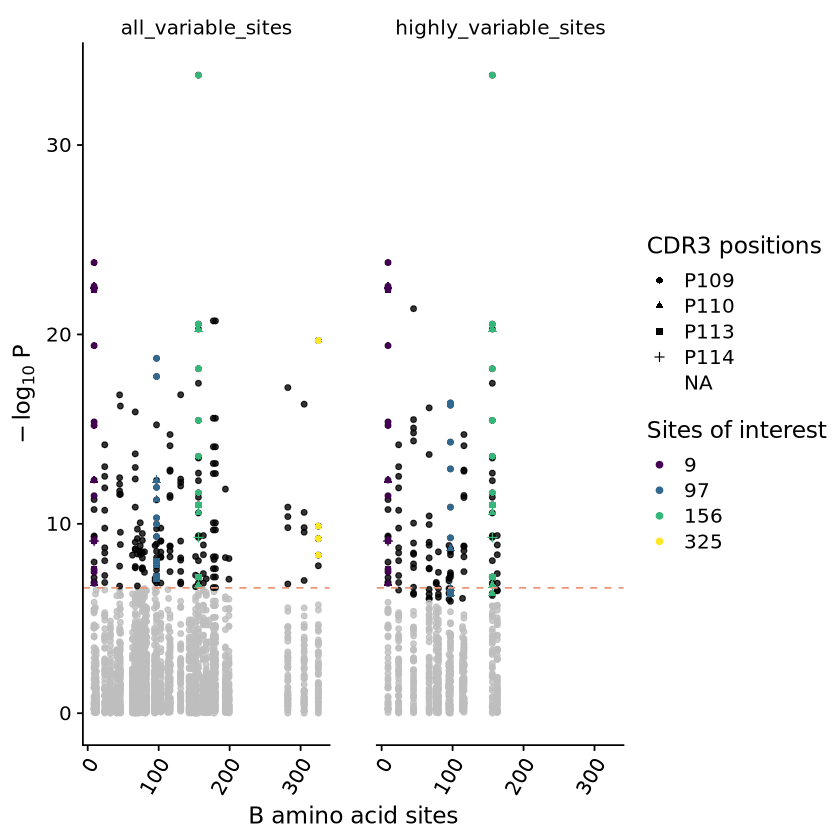

In [54]:
pl_hla_manh <- ggplot() + 
    geom_point(data = hla_interest, aes(x = site, y = -log10(Pr..F.), color = significance), alpha=0.8, size=1.3) +
    scale_color_manual(values = c('yes' = 'black', 'no' = 'grey')) +
    guides(color = "none") +
    labs(x = "B amino acid sites", y = expression(paste(-log[10], " ", P))) + 
    new_scale_color() + 
    geom_point(data = hla_interest_sites_of_interest, aes(x=site, y = -log10(Pr..F.), color = factor(site), shape = factor(highlighed_cdr3_positions))) +
    labs(color = "Sites of interest", shape = "CDR3 positions") +
    #scale_color_manual(values = c('13' = 'deeppink3')) +
    #geom_point(data = drb1_ref %>% filter(feature %in% c('Antigen_binding', 'Glycosylation', 'Phosphoserine')), 
              #aes(x = start, y = -1, shape = feature)) +
    #scale_shape_manual(values = ifelse("Antigen_binding" = 13, 'no' = 23) , guide = "none" , drop = FALSE, na.translate = TRUE) +
    scale_color_viridis_d() +
    geom_hline(yintercept= - log10(bonf), linetype="dashed", color = "darksalmon") +
    theme(legend = 'none') +
    theme_cowplot() +
    theme(axis.text.x = element_text(angle = 60, hjust = 1), strip.background = element_rect(fill = "white")) +
    new_scale_color() + 
    #geom_segment(aes(x = 13, xend = 87, y=-1, yend = -1, colour = 'Beta domain')) +
    #geom_segment(aes(x = 97, xend = 185, y=-1, yend = -1, colour = 'Ig-like C1 type domain')) +
    #scale_color_manual(values = c('Beta domain' = 'deeppink3', 'Ig-like C1 type domain' = 'brown1')) +
    #theme(legend.position = "bottom", legend.text = 'CDR3 position') +
    facet_wrap(~batch) +
    theme(panel.spacing = unit(1, "cm"))
    
    
    

pl_hla_manh
               
ggsave('../plots/B.jpg',pl_hla_manh, width = 10, height = 4)

### Visualisation of variance explained

In [ ]:
pl <- ggplot(manova_df_all) +
    geom_point(aes(x = site, y = -log10(Pr..F.), color=as.factor(gene)), alpha=0.8, size=1.3, show.legend = FALSE) +
    scale_color_viridis_d() +
    scale_x_continuous(breaks = as.integer(seq(0, 300, length.out = 5))) +
    labs(x = "HLA amino acid site", y = expression(paste(-log[10], " ", P))) +
    geom_hline(yintercept= - log10(bonf), linetype="dashed", color = "red") +
    theme(legend.position = "none") +
    theme_cowplot() +
    facet_grid(~gene, space = "free") +
    theme(axis.text.x = element_text(angle = 60, hjust = 1), strip.background = element_rect(fill = "white")) #+
    #geom_segment(data = hla_annotation, aes(x = start, xend = end, y=-0.01, yend=-0.01), color = 'blue', label = NA)
pl
ggsave('../data/TRB_samples/plots/trb_manova_annotated.jpg',pl, width = 10, height = 4)
